In [0]:
import pandas as pd
import numpy as np
import re
import torch
import torch.nn as nn
import random
import torch.nn.functional as F
from gensim.models import FastText
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
data = pd.read_csv('/content/drive/My Drive/Amazon_Food/Reviews.csv')
len(data)

568454

In [4]:
data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [0]:
x = data['Text']
y = data['Summary']

In [0]:
def clean(text):
  text = str(text)
  text = text.lower()
  text = re.sub(r'\'s',r'\tis',text)
  text = re.sub(r'\'ll',r'\twill',text)
  text = re.sub(r'\'m',r'\tam',text)
  text = re.sub(r'\'re',r'\tare',text)
  text = re.sub(r'\'d',r'\twould',text)
  text = re.sub(r'n\'t',r'\tnot',text)
  text = re.sub('[^a-zA-Z0-9]',' ',text) 
  text = re.sub(r"[-()\"#/@;:<>{}`+=~|.!?,]", "", text)
  return text

In [7]:
cleaned_source = list(map(clean,x))
cleaned_summary = list(map(clean,y))

for i in range(len(cleaned_summary)):
    cleaned_summary[i] = "<START> " + cleaned_summary[i] + " <END>"
    
print(cleaned_source[11])
print(cleaned_summary[11])

one of my boys needed to lose some weight and the other did not   i put this food on the floor for the chubby guy  and the protein rich  no by product food up higher where only my skinny boy can jump   the higher food sits going stale   they both really go for this food   and my chubby boy has been losing about an ounce a week 
<START> my cats love this  diet  food better than their regular food <END>


In [8]:
min_source_length = 1999999
max_source_length = 0
min_target_length = 199999
max_target_length = 0

for i in range(len(data)):
  min_source_length = min(min_source_length,len(cleaned_source[i].split()))
  min_target_length = min(min_target_length,len(cleaned_summary[i].split()))
  max_source_length = max(max_source_length,len(cleaned_source[i].split()))
  max_target_length = max(max_target_length,len(cleaned_summary[i].split()))

print("Minimum source length is:  ",min_source_length)
print("Minimum target length is:  ",min_target_length)
print("Maximum source length is:  ",max_source_length)
print("Maximum target length is:  ",max_target_length)

Minimum source length is:   3
Minimum target length is:   2
Maximum source length is:   3529
Maximum target length is:   50


In [9]:
new_source = []
new_summary = []

for i in range(len(cleaned_source)):
  if len(cleaned_source[i].split()) <= 50 and len(cleaned_summary[i].split()) <= 15 :
    new_source.append(cleaned_source[i])
    new_summary.append(cleaned_summary[i])

max_source_length = 50
max_summary_length = 15

print(len(new_source))
print(len(new_summary))

new_source = new_source[:30000]
new_summary = new_summary[:30000]

245024
245024


In [10]:
sentences = new_source + new_summary
sent_ted = []
for sent in sentences:
  sent_ted_child = sent.split()
  sent_ted.append(sent_ted_child)

print(sent_ted[0])

['i', 'have', 'bought', 'several', 'of', 'the', 'vitality', 'canned', 'dog', 'food', 'products', 'and', 'have', 'found', 'them', 'all', 'to', 'be', 'of', 'good', 'quality', 'the', 'product', 'looks', 'more', 'like', 'a', 'stew', 'than', 'a', 'processed', 'meat', 'and', 'it', 'smells', 'better', 'my', 'labrador', 'is', 'finicky', 'and', 'she', 'appreciates', 'this', 'product', 'better', 'than', 'most']


In [0]:
# from gensim.models import FastText
# model_ted = FastText(sent_ted, size=128, window=3, min_count=1, workers=4,sg=1, iter=1500)

# import pickle
# pickle.dump(model_ted, open('128_emb_1lakhdata.pkl', 'wb'))

In [24]:
import pickle
model_ted = pickle.load(open('/content/drive/My Drive/128_emb.pkl', 'rb'))
weights = model_ted.wv
print(model_ted.wv.most_similar("milk"))

[('skim', 0.5355638265609741), ('milks', 0.5320084095001221), ('water', 0.5292779207229614), ('foggy', 0.5185288190841675), ('creamer', 0.5173667669296265), ('wipping', 0.5089503526687622), ('raisan', 0.5022526383399963), ('floz', 0.4988960325717926), ('truvia', 0.4962727725505829), ('frother', 0.4953957200050354)]


/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


In [0]:
from collections import OrderedDict 

word2Index_enc = {}
word2Index_dec = {}
word2Index_dec_big = {}

ind2Word_enc = {}
ind2Word_dec = {}
ind2Word_dec_big = {}

word2PsuInd_dec = {}
psuInd2Word_dec = {}

encoder_paragraph = list(set((' '.join(new_source)).split()))

decoder_paragraph_list = list((' '.join(new_summary)).split())
decoder_dict = OrderedDict()
for word in decoder_paragraph_list:
  try:
    decoder_dict[word] = decoder_dict[word] + 1
  except:
    decoder_dict[word] = 1

ind2Word_enc[0] = '<UNK>'
ind2Word_dec[0] = '<UNK>'
word2Index_enc['<UNK>'] = 0
word2Index_dec['<UNK>'] = 0
ind2Word_dec_big[0] = '<UNK>'
word2Index_dec_big['<UNK>'] = 0
word2PsuInd_dec['<UNK>'] = 0
psuInd2Word_dec[0] = '<UNK>'

dec_index = 1
for (decoder_dict_word, decoder_dict_number) in decoder_dict.items():
  word2Index_dec_big[decoder_dict_word] = dec_index
  ind2Word_dec_big[dec_index] = decoder_dict_word
  if decoder_dict_number >= 3 :
    word2Index_dec[decoder_dict_word] = dec_index
    ind2Word_dec[dec_index] = decoder_dict_word
    psuedo_index = len(word2PsuInd_dec.keys())
    word2PsuInd_dec[decoder_dict_word] = psuedo_index
    psuInd2Word_dec[psuedo_index] = decoder_dict_word
  dec_index+=1

enc_index = 1
for index,word in enumerate(encoder_paragraph):
  if word != ' ':
    word2Index_enc[word] = enc_index
    ind2Word_enc[enc_index] = word 
    enc_index+=1


In [13]:
print("Decoder vocabulary size",len(word2Index_dec.keys()))
print("Encoder vocabulary size",len(word2Index_enc.keys()))

Decoder vocabulary size 2786
Encoder vocabulary size 18827


In [0]:
encoder_input = [[word2Index_enc[word] for word in sentence.split() if word in word2Index_enc.keys()] for sentence in new_source ]
decoder_input = [[word2Index_dec_big[word] for word in sentence.split() if word in word2Index_dec_big.keys()] for sentence in new_summary ]

In [0]:
encoder_tensor = [torch.tensor(li,dtype=torch.long,device=device).view(-1, 1) for li in encoder_input]
decoder_tensor = [torch.tensor(li,dtype=torch.long,device=device).view(-1, 1) for li in decoder_input]

In [0]:
class Encoder(nn.Module):
  def __init__(self,input_vocab_size,hidden_size,num_layers=1,bidirectional=False):
    super(Encoder,self).__init__()
    self.bidirectional = bidirectional
    self.num_layers = num_layers
    self.hidden_size = hidden_size
    self.input_vocab_size = input_vocab_size
    self.gru_layer = nn.GRU(input_size = self.hidden_size,hidden_size = self.hidden_size,num_layers = self.num_layers)

  def forward(self,input_,prev_hidden_state):
    input_word = ind2Word_enc[input_.data.tolist()[0]]
    embedded_outputs = torch.tensor(weights[input_word], device = device).view(1,1,-1)
    output,prev_hidden_state = self.gru_layer(embedded_outputs,prev_hidden_state)  #output is batch_size times hidden_size
    return output,prev_hidden_state

  def init_hidden(self):
    return torch.zeros(1,1,self.hidden_size,device=device)

In [0]:
class AttentionDecoder(nn.Module):
  def __init__(self,output_vocab_size,hidden_size,max_length_encoder,dropout_value,num_layers=1):
      super(AttentionDecoder,self).__init__()
      self.hidden_size = hidden_size
      self.num_layers = num_layers
      self.output_vocab_size = output_vocab_size
      self.dropout_p = dropout_value
      self.max_length_encoder = max_length_encoder
      self.embedding_layer = nn.Embedding(self.output_vocab_size,self.hidden_size)
      self.attention_layer = nn.Linear(self.hidden_size*2,self.max_length_encoder)
      self.attention_combine = nn.Linear(self.hidden_size*2,self.hidden_size)

      self.s_layer = nn.Linear(self.hidden_size, 1)
      self.x_layer = nn.Linear(self.hidden_size, 1)
      self.context_layer = nn.Linear(self.hidden_size, 1)
      self.linear_pgen = nn.Linear(3, 1)

      self.gru_layer = nn.GRU(self.hidden_size,self.hidden_size)
      self.output_layer = nn.Linear(self.hidden_size,self.output_vocab_size)
      self.dropout_layer = nn.Dropout(self.dropout_p)    

  def forward(self,input_,prev_hidden_state,encoder_output,prev_unk_word):
      input_word = ind2Word_dec_big[input_.data.tolist()[0]]
      if input_word == '<UNK>':
        embedded_outputs = torch.tensor(weights[prev_unk_word], device = device).view(1,1,-1)
      else:
        embedded_outputs = torch.tensor(weights[input_word], device = device).view(1,1,-1)
        
      embeddings_dropout = self.dropout_layer(embedded_outputs)
      attention_layer_output = self.attention_layer(torch.cat((embeddings_dropout[0],prev_hidden_state[0]),1))
      attention_weights = nn.functional.softmax(attention_layer_output,dim=1)
      attention_applied = torch.bmm(attention_weights.unsqueeze(0),encoder_output.unsqueeze(0))
      attention_combine_logits = self.attention_combine(torch.cat((embeddings_dropout[0],attention_applied[0]),1)).unsqueeze(0)  #since gru requires a batch dimension
      attention_combine_relu = nn.functional.relu(attention_combine_logits)

      s_output = self.s_layer(prev_hidden_state[0])
      x_output = self.x_layer(embeddings_dropout[0])
      context = torch.flatten(attention_applied)
      context_weights = self.context_layer(attention_applied)
      sx = torch.cat((s_output[0],x_output[0]),0)
      sxc = torch.cat((sx,context_weights[0][0]),0)
      linear_pgen = self.linear_pgen(sxc)
      m = nn.Sigmoid()
      pgen = m(linear_pgen)

      output,hidden = self.gru_layer(attention_combine_relu,prev_hidden_state)
      output_logits = self.output_layer(output)
      output_softmax = nn.functional.log_softmax(output_logits[0],dim=1)
      return output_softmax,hidden,attention_weights,pgen

  def init_hidden(self):
    return torch.zeros(1,1,self.hidden_size,device=device)

In [0]:
teacher_forcing_ratio = 0.5

def train(encoder, decoder, input_tensor, target_tensor, encoder_optimizer, decoder_optimizer, criterion, max_length, iters):

  encoder_optimizer.zero_grad()
  decoder_optimizer.zero_grad()

  prev_unk_word = ''

  encoder_hidden = encoder.init_hidden()

  encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device = device)

  input_length = input_tensor.size(0)
  output_length = target_tensor.size(0)

  loss = 0

  for encoder_index in range(0, input_length):
    encoder_output,encoder_hidden = encoder(input_tensor[encoder_index], encoder_hidden)
    encoder_outputs[encoder_index] = encoder_output[0,0]

  decoder_input = torch.tensor([word2Index_dec['<START>']],device=device)   
  decoder_hidden = encoder_hidden
  use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

  extended_vocab = psuInd2Word_dec.copy()
  reverse_extended_vocab = word2PsuInd_dec.copy()
  duplicate_words = {}
  extend_key = len(word2Index_dec.keys())
  input_list = input_tensor.tolist()
  i =0
  for input_word in input_list:
    if ind2Word_enc[input_word[0]] in word2Index_dec.keys():
      duplicate_words[i] = word2PsuInd_dec[ind2Word_enc[input_word[0]]]
    else:
      extended_vocab[extend_key] = ind2Word_enc[input_word[0]]
      reverse_extended_vocab[ind2Word_enc[input_word[0]]] = extend_key
      extend_key += 1
    i = i+1

  if use_teacher_forcing:
    for decoder_index in range(output_length):
      decoder_output,decoder_hidden,decoder_attention,pgen = decoder(decoder_input,decoder_hidden,encoder_outputs,prev_unk_word)
      P_over_extended_vocab = torch.exp(decoder_output)*pgen.expand_as(torch.exp(decoder_output))

      decoder_attention = decoder_attention.squeeze(0)[0:input_length].unsqueeze(0)
      p_duplicate_list = torch.zeros([input_length, P_over_extended_vocab.size(1)], device=device)
      p_duplicate_list = p_duplicate_list.tolist()
      for (duplicate_word_key,duplicate_word_value) in duplicate_words.items():
        p_duplicate_list[duplicate_word_key][duplicate_word_value] = 1
      p_duplicate = torch.tensor(p_duplicate_list, dtype=torch.float, device=device)
      p_diag = torch.mm(decoder_attention, p_duplicate)
      p_diag = p_diag*(torch.tensor([1], device=device).sub(pgen)).expand_as(p_diag)
      p_add_diag = torch.diag(p_diag.squeeze(0),diagonal=0)
      P_over_extended_vocab = torch.mm(P_over_extended_vocab,p_add_diag).add(P_over_extended_vocab)

      for i in range(input_length):
        if not (1 in p_duplicate_list[i]):
          P_over_extended_vocab = torch.cat((P_over_extended_vocab[0], torch.mm(decoder_attention.squeeze(0)[i].unsqueeze(0).unsqueeze(0), torch.tensor([1], device=device).sub(pgen).unsqueeze(0)).squeeze(0)),0).unsqueeze(0)

      try:
        loss += -torch.log(P_over_extended_vocab[0][ reverse_extended_vocab[ ind2Word_dec_big[ target_tensor[decoder_index].item() ] ] ] + 1e-12)
        loss.backward(retain_graph=True)
      except KeyError:
        loss += torch.tensor(0,dtype=torch.float,device=device)
      decoder_input = target_tensor[decoder_index]
  else:

    for decoder_index in range(output_length):
      decoder_output,decoder_hidden,decoder_attention,pgen = decoder(decoder_input,decoder_hidden,encoder_outputs,prev_unk_word) 
      P_over_extended_vocab = torch.exp(decoder_output)*pgen.expand_as(torch.exp(decoder_output))

      decoder_attention = decoder_attention.squeeze(0)[0:input_length].unsqueeze(0)
      p_duplicate_list = torch.zeros([input_length, P_over_extended_vocab.size(1)], device=device)
      p_duplicate_list = p_duplicate_list.tolist()
      for (duplicate_word_key,duplicate_word_value) in duplicate_words.items():
        p_duplicate_list[duplicate_word_key][duplicate_word_value] = 1
      p_duplicate = torch.tensor(p_duplicate_list, dtype=torch.float, device=device)
      p_diag = torch.mm(decoder_attention, p_duplicate)
      p_diag = p_diag*(torch.tensor([1], device=device).sub(pgen)).expand_as(p_diag)
      p_add_diag = torch.diag(p_diag.squeeze(0),diagonal=0)
      P_over_extended_vocab = torch.mm(P_over_extended_vocab,p_add_diag).add(P_over_extended_vocab)

      for i in range(input_length):
        if not (1 in p_duplicate_list[i]):
          P_over_extended_vocab = torch.cat((P_over_extended_vocab[0], torch.mm(decoder_attention.squeeze(0)[i].unsqueeze(0).unsqueeze(0), torch.tensor([1], device=device).sub(pgen).unsqueeze(0)).squeeze(0)),0).unsqueeze(0)

      try:
        loss += -torch.log(P_over_extended_vocab[0][ reverse_extended_vocab[ ind2Word_dec_big[ target_tensor[decoder_index].item() ] ] ] + 1e-12)
        loss.backward(retain_graph=True)
      except KeyError:
        loss += torch.tensor(0,dtype=torch.float,device=device)
      idx = torch.topk(P_over_extended_vocab, k=1, dim=1)[1]
      if idx.item() < len(word2Index_dec.keys()):   
        decoder_input = torch.tensor([idx.item()],dtype=torch.long,device=device)
      elif idx.item() >= len(word2Index_dec.keys()):
        prev_unk_word = extended_vocab[idx.item()]
        decoder_input = torch.tensor([0],dtype=torch.long,device=device)
      elif (decoder_input.item() == word2Index_dec['<END>']):
        break

  if iters > 20000:
    torch.nn.utils.clip_grad_norm_(rnn_encoder.parameters(),0.4)
    torch.nn.utils.clip_grad_norm_(rnn_decoder.parameters(),0.4)

  encoder_optimizer.step()
  decoder_optimizer.step()

  return loss.item()/output_length

In [0]:
import time
import math


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    if percent != 0:
      es = s / (percent)
      rs = es - s
      return '%s (- %s)' % (asMinutes(s), asMinutes(rs))
    else:
      return 0

In [0]:
arr = np.arange(len(encoder_tensor))
np.random.shuffle(arr)
len(arr)

In [0]:
# Dictionary for creating loss graph
loss_graph = {}

def train_Iters(encoder,decoder,n_iters,print_every=50, plot_every=100,learning_rate = 0.03):
  # start = time.time()
  plot_losses = []
  print_loss_total = 0  # Reset every print_every
  plot_loss_total = 0

  encoder_optimizer = torch.optim.SGD(encoder.parameters(), lr=learning_rate)
  decoder_optimizer = torch.optim.SGD(decoder.parameters(), lr=learning_rate)
  training_pairs = [random.choice(pairs) for i in range(n_iters)]
  
  criterion = nn.NLLLoss()
  for iters in range(n_iters):
    training_pair = training_pairs[iters - 1]
    input_tensor = training_pair[0]
    target_tensor = training_pair[1]

    input_tensor = torch.tensor(input_tensor, dtype=torch.long, device = device).view(-1, 1)
    target_tensor = torch.tensor(target_tensor, dtype=torch.long, device = device).view(-1, 1)

    loss = train(encoder,decoder,input_tensor,target_tensor,encoder_optimizer,decoder_optimizer,criterion,max_source_length, iters)
    print_loss_total += loss
    plot_loss_total += loss

    if iters % print_every == 0:
        print_loss_avg = print_loss_total / print_every
        print_loss_total = 0
        print('%s %d%%) %.4f' % (iters, iters / len(arr) * 100, print_loss_avg))

        if iters > 0:
          loss_graph[iters] = print_loss_avg

    if iters % plot_every == 0:
        plot_loss_avg = plot_loss_total / plot_every
        plot_losses.append(plot_loss_avg)
        plot_loss_total = 0

  # showPlot(plot_losses)
  

In [0]:
import matplotlib.pyplot as plt
plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np


def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

In [0]:
pairs = []
for enc,dec in zip(encoder_input,decoder_input):
    pairs.append([enc,dec])

In [51]:
hidden_size = 128
rnn_encoder = Encoder(len(word2Index_enc.keys()),hidden_size).to(device=device)
rnn_decoder = AttentionDecoder(len(word2Index_dec.keys()),hidden_size,max_source_length,0.2).to(device=device)

train_Iters(rnn_encoder,rnn_decoder,100000)

0 0%) 0.1768
50 0%) 5.4431
100 0%) 4.8154
150 0%) 4.5362
200 0%) 4.7026
250 0%) 4.7144
300 1%) 4.5535
350 1%) 4.2123
400 1%) 4.2582
450 1%) 4.6562
500 1%) 4.3248
550 1%) 4.3570
600 2%) 4.1034
650 2%) 4.4397
700 2%) 4.1432
750 2%) 4.2782
800 2%) 4.2599
850 2%) 4.2046
900 3%) 4.0812
950 3%) 4.0749
1000 3%) 4.1208
1050 3%) 4.2579
1100 3%) 4.1653
1150 3%) 3.9679
1200 4%) 4.3853
1250 4%) 4.3869
1300 4%) 3.9935
1350 4%) 3.8368
1400 4%) 3.9361
1450 4%) 4.0907
1500 5%) 3.9974
1550 5%) 3.9242
1600 5%) 4.0037
1650 5%) 4.1252
1700 5%) 4.1093
1750 5%) 3.9566
1800 6%) 3.9977
1850 6%) 4.2370
1900 6%) 4.0446
1950 6%) 4.0646
2000 6%) 4.1106
2050 6%) 3.9392
2100 7%) 4.2062
2150 7%) 4.3813
2200 7%) 4.4225
2250 7%) 4.0551
2300 7%) 3.8839
2350 7%) 3.9797
2400 8%) 3.9289
2450 8%) 3.8677
2500 8%) 3.7976
2550 8%) 3.8575
2600 8%) 3.8552
2650 8%) 3.9993
2700 9%) 3.9557
2750 9%) 3.8115
2800 9%) 4.1785
2850 9%) 4.0981
2900 9%) 3.7647
2950 9%) 3.8231
3000 10%) 4.0047
3050 10%) 4.3761
3100 10%) 4.1745
3150 10%) 3.

KeyboardInterrupt: ignored

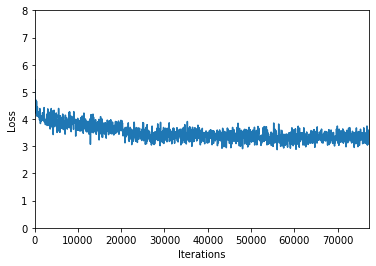

In [53]:
import matplotlib.pyplot as plt

iters = list(loss_graph.keys())
loss_val = list(loss_graph.values())
plt.plot(iters, loss_val)
plt.ylim(0,8) 
plt.xlim(0,77350)
plt.xlabel('Iterations') 
plt.ylabel('Loss')  
plt.show()

In [0]:
def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        pair1 = torch.tensor(pair[0],dtype=torch.long,device=device)
        pair2 = pair[1]
        output_words, attentions = evaluate(encoder, decoder, pair1)
        output_sentence = ' '.join(output_words)
        output_list = [ind2Word_dec_big[word] for word in pair2]
        output_list = ' '.join(output_list)
        input_sentence = [ind2Word_enc[element.item()] for element in pair1.flatten()]
        input_sentence = ' '.join(input_sentence)
        print("Sentence is  ",input_sentence)
        print('<',output_sentence)
        print('=',output_list)

In [0]:
def evaluate(encoder, decoder, encoder_tensor, max_length=max_source_length):
    with torch.no_grad():
        input_tensor = encoder_tensor
        input_length = input_tensor.size(0)
        encoder_hidden = encoder.init_hidden()

        prev_unk_word = ''

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei].unsqueeze(0),
                                                     encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        extended_vocab = psuInd2Word_dec.copy()
        duplicate_words = {}
        extend_key = len(word2Index_dec.keys())
        input_list = input_tensor.tolist()
        i =0
        for input_word in input_list:
          if ind2Word_enc[input_word] in word2Index_dec.keys():
            duplicate_words[i] = word2PsuInd_dec[ind2Word_enc[input_word]]
          else:
            extended_vocab[extend_key] = ind2Word_enc[input_word]
            extend_key += 1
          i = i+1

        decoder_input = torch.tensor([word2Index_dec['<START>']], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_attention,pgen = decoder(
                decoder_input, decoder_hidden, encoder_outputs, prev_unk_word)
            decoder_attentions[di] = decoder_attention.data

            P_over_extended_vocab = torch.exp(decoder_output)*pgen.expand_as(torch.exp(decoder_output))

            decoder_attention = decoder_attention.squeeze(0)[0:input_length].unsqueeze(0)
            p_duplicate_list = torch.zeros([input_length, P_over_extended_vocab.size(1)], device=device)
            p_duplicate_list = p_duplicate_list.tolist()
            for (duplicate_word_key,duplicate_word_value) in duplicate_words.items():
              p_duplicate_list[duplicate_word_key][duplicate_word_value] = 1
            p_duplicate = torch.tensor(p_duplicate_list, dtype=torch.float, device=device)
            p_diag = torch.mm(decoder_attention, p_duplicate)
            p_diag = p_diag*(torch.tensor([1], device=device).sub(pgen)).expand_as(p_diag)
            p_add_diag = torch.diag(p_diag.squeeze(0),diagonal=0)
            P_over_extended_vocab = torch.mm(P_over_extended_vocab,p_add_diag).add(P_over_extended_vocab)

            for i in range(input_length):
              if not (1 in p_duplicate_list[i]):
                P_over_extended_vocab = torch.cat((P_over_extended_vocab[0], torch.mm(decoder_attention.squeeze(0)[i].unsqueeze(0).unsqueeze(0), torch.tensor([1], device=device).sub(pgen).unsqueeze(0)).squeeze(0)),0).unsqueeze(0)

            idx = torch.topk(P_over_extended_vocab, k=1, dim=1)[1]
            if idx.item() < len(word2Index_dec.keys()):   
              decoder_input = torch.tensor([idx.item()],dtype=torch.long,device=device)
              decoded_words.append(extended_vocab[idx.item()])
            elif idx.item() >= len(word2Index_dec.keys()):
              decoder_input = torch.tensor([0],dtype=torch.long,device=device)
              prev_unk_word = extended_vocab[idx.item()]
              decoded_words.append(extended_vocab[idx.item()])
            if idx.item() == word2Index_dec['<END>']:
              decoded_words.append('<END>')
              break

        return decoded_words, decoder_attentions[:di + 1]

In [0]:
evaluateRandomly(rnn_encoder, rnn_decoder)

tensor([0.9997], device='cuda:0')
tensor([0.9987], device='cuda:0')
tensor([0.9959], device='cuda:0')
tensor([0.9942], device='cuda:0')
tensor([0.9919], device='cuda:0')
Sentence is   tastes as if they colored the peppermint altoids green stronger than original and definitely not spearmint flavored original had pleasant mildly sweet taste have not we learned from coca cola to leave well enough alone
< <START> not not not <END> <END>
= <START> nasty <END>
tensor([0.9985], device='cuda:0')
tensor([0.9947], device='cuda:0')
tensor([0.9990], device='cuda:0')
tensor([0.9995], device='cuda:0')
tensor([0.9994], device='cuda:0')
tensor([0.9994], device='cuda:0')
Sentence is   this chicken was a gift and it arrived on time and was well liked fast service and good quality
< <START> very to to to <END> <END>
= <START> great quality <END>
tensor([0.9986], device='cuda:0')
tensor([0.9918], device='cuda:0')
tensor([0.9791], device='cuda:0')
tensor([0.9670], device='cuda:0')
tensor([0.9792], device='

In [0]:
torch.save(rnn_encoder,'/content/drive/My Drive/News_Summary/nm_a_encoder_attn_ptr_many_iter_30kdata_amazon.h5')

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Encoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [0]:
torch.save(rnn_decoder,'/content/drive/My Drive/News_Summary/nm_a_decoder_attn_ptr_many_iter_30kdata_amazon.h5')

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type AttentionDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [0]:
rnn_encoder = torch.load('/content/drive/My Drive/News_Summary/nm_a_encoder_attn_ptr_many_iter_30kdata_amazon.h5', map_location=torch.device('cpu'))

In [0]:
rnn_decoder = torch.load('/content/drive/My Drive/News_Summary/nm_a_decoder_attn_ptr_many_iter_30kdata_amazon.h5', map_location=torch.device('cpu'))